# Warp, Threshold and Map to rover specific coordinates
To make a map of the environment, you're going to first apply a perspective transform and then apply a color threshold (or vice versa, doesn't really matter). This color thresholded image is now a map of the navigable terrain in front of the rover! 

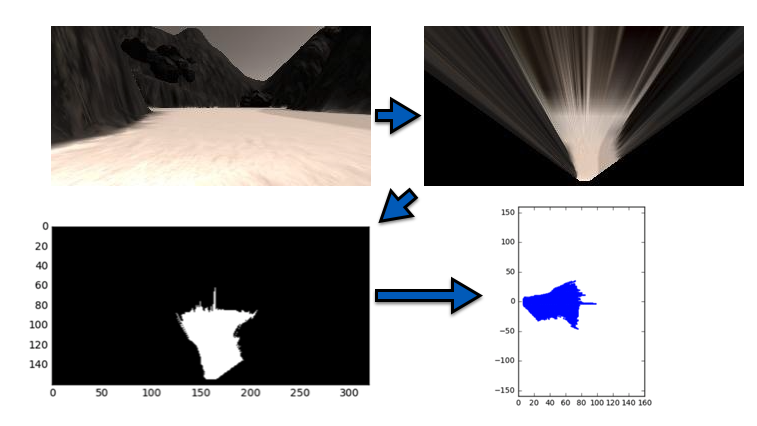

The callenge is to transform the rover specific coordinates in respect to the world coordinates.

The notion of a coordinate system that is fixed with respect to your robot is central to many robotics applications. Such a coordinate system allows you to describe the positions of things in the environment with respect to the robot, in this case, the rover (or more specifically, the rover's camera). 

Cartesian (real-world) right hand rule:

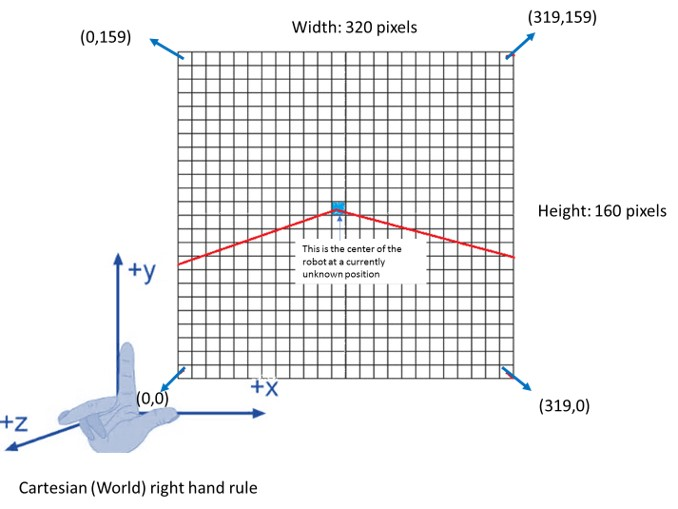


When working with reference frames, keep in mind that ROS uses a right-hand convention for orienting the coordinate axes as shown on left.  Similarly, the direction of rotations about an axis is defined by the right hand rule shown on the right:  if you point your thumb in the positive direction of any axis, your fingers curl in the direction of a positive rotation.  For a mobile robot using ROS, the z-axis points upward, the x-axis points forward, and the y-axis points to the left.  Under the right-hand rule, a positive rotation of the robot about the z-axis is counterclockwise while a negative rotation is clockwise.

Simple rule. From robots view:

The index finger is pointing forward as your X
y is then to your left and z is up.


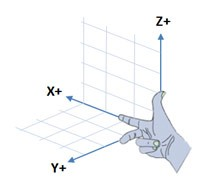

That means for a specific position (x,y,z) in thereal world represented by the cartesian system the perspective of the rover needs to be translated to the real world cartesian system. This means in this case that the x and y axis need to be shifted. To make the coordinates rover centric the /2 is executed to allow it to centre at 0 as a view point.

in addition the adjustments for the camera hight and viewing angle are executed.

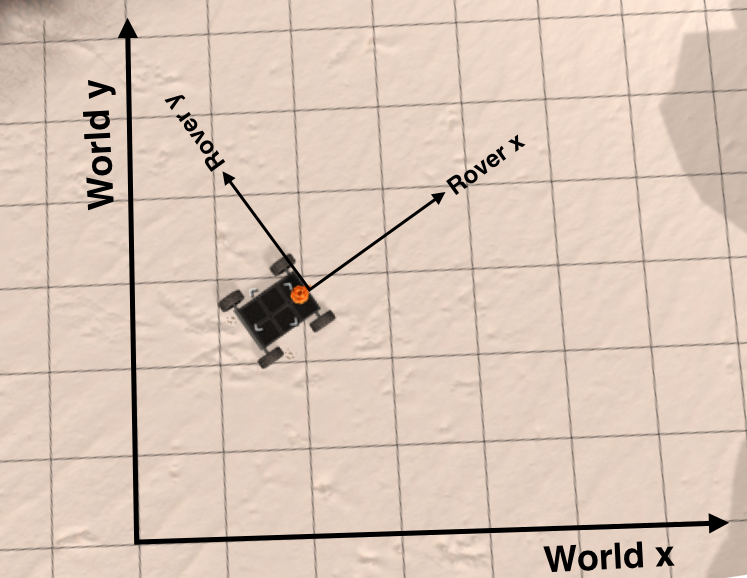


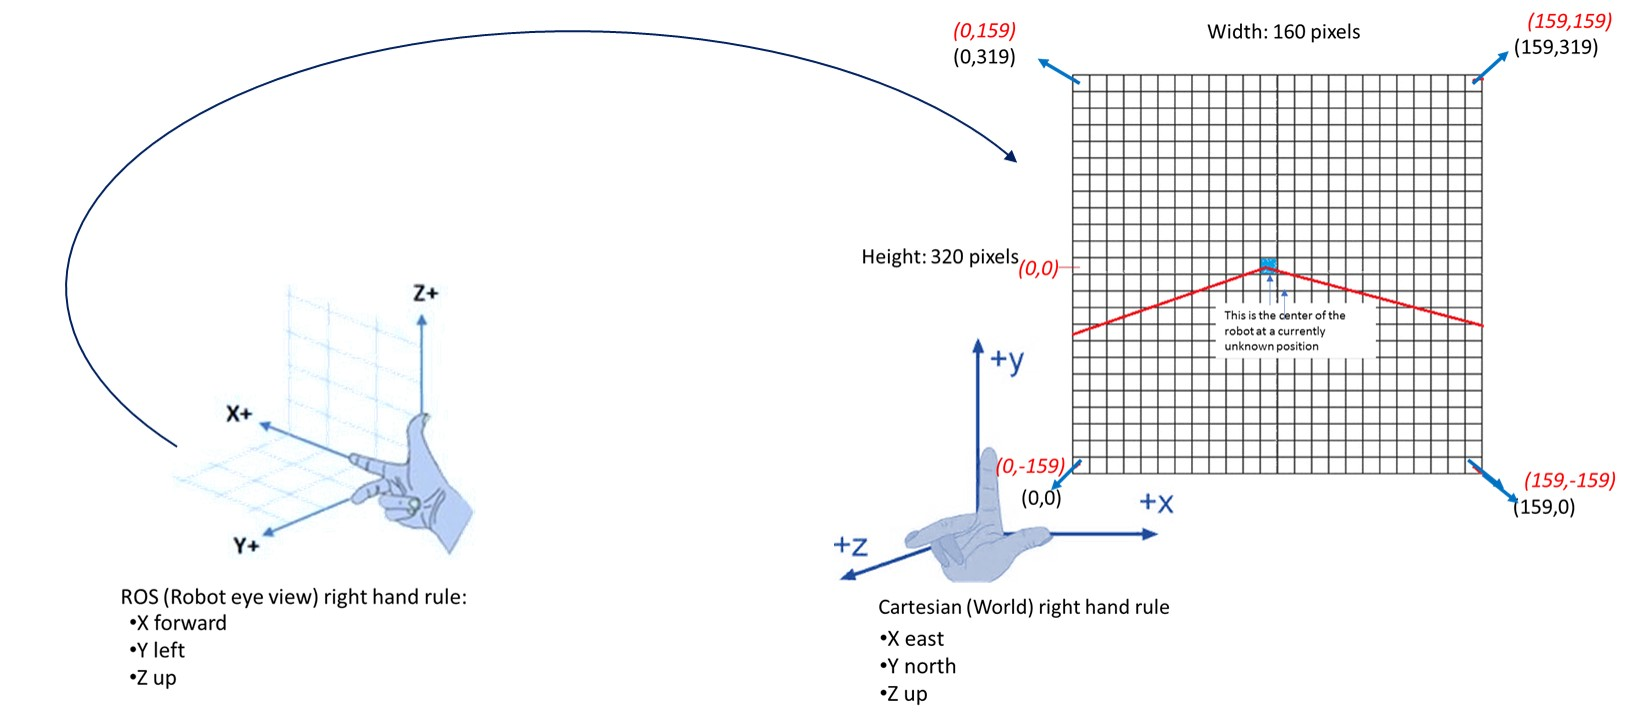

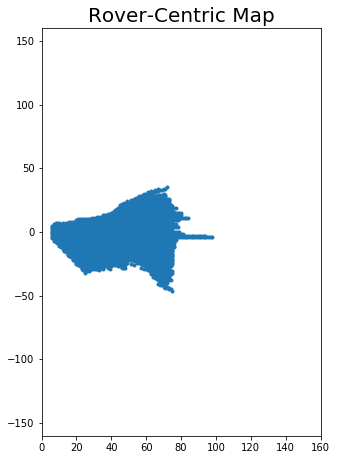

In [6]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def perspect_transform(img, src, dst):

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped
                  
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select
    
image = mpimg.imread('sample.jpg')
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# image.shape[0] is the 160 pixels in y direction
# image.shape[1] is the 320 pixels in x direction
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])


# Read in the sample image
image = mpimg.imread('sample.jpg')


def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Perform warping and color thresholding
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract x and y positions of navigable terrain pixels
# and convert to rover coordinates
xpix, ypix = rover_coords(colorsel)

# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)
plt.show() # Uncomment if running on your local machine